# Generative model for SDSS spectra

The goal is to generate synthetic galaxy spectra from the probability distribution sampled by measured SDSS spectra.

The data can be read as follows. Make sure you have the file `sdss_galaxy_spec.hdf5` from the [google drive](https://drive.google.com/drive/u/1/folders/13ySEme-B8XDMYgTZ8_rVpMarRUUGYbTw) downloaded or the google drive linked to your google colab instance.

In [1]:
import math
import h5py
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def normalizing(specs, min_val, max_val):
    return 2 * (specs - min_val) / (max_val - min_val) - 1

def denormalizing(norm_specs, min_val, max_val):
    return (norm_specs + 1) / 2 * (max_val - min_val) + min_val

In [54]:
base = 'TODO'

with h5py.File(f'/content/drive/MyDrive/M2/A3net/group_h/sdss_galaxy_spec.hdf5', 'r') as fp :

    # redshift
    z = fp['raw']['z'][...]

    # physical properties
    ages = fp['raw']['age'][...]
    metallicity = fp['raw']['metallicity'][...]
    smass = fp['raw']['smass'][...]

    # spectra, including error bars
    wavelength = fp['raw']['wavelength'][...]
    specs = fp['raw']['spec'][...]
    specerrs = fp['raw']['specerr'][...]


# Normalizing specs
# smass[smass < 0] = 100000 #some smass values are <0, so it better to avoid use these values
# smass = np.log10(smass)
# specs = (specs - specs.min()) / (specs.max() - specs.min())
# metallicity = (metallicity - metallicity.min()) / (metallicity.max() - metallicity.min())

In [55]:
smass

array([4.4742600e+09, 1.0490611e+10, 7.8120264e+10, ..., 5.8471150e+10,
       2.1091615e+11, 4.9049412e+10], dtype=float32)

In [56]:
specs_norm = []
metallicity_norm = []
smass_norm = []
ages_norm = []
z_norm = []
for spec in specs:
    # spec = (spec-spec.min())/(spec.max()-spec.min())
    spec = normalizing(spec, spec.min(), spec.max())
    specs_norm.append(spec)
for m in metallicity:
    # m = (m-metallicity.min())/(metallicity.max()-metallicity.min())
    m = normalizing(m, metallicity.min(), metallicity.max())
    metallicity_norm.append(m)
for mass in smass:
    mass = normalizing(mass, smass.min(), smass.max())
    smass_norm.append(mass)
for age in ages:
    age = normalizing(age, ages.min(), ages.max())
    ages_norm.append(age)
for rs in z:
    rs = normalizing(rs, z.min(), z.max())
    z_norm.append(rs)
specs = np.array(specs_norm)
metallicity = np.array(metallicity_norm)
smass = np.array(smass_norm)
ages = np.array(ages_norm)
z = np.array(z_norm)

In [57]:
metallicity

array([0.9998883 , 0.99986315, 0.99969554, ..., 0.99982715, 0.9996543 ,
       0.99979675], dtype=float32)

Let's have a quick look:

Text(0, 0.5, 'spectrum')

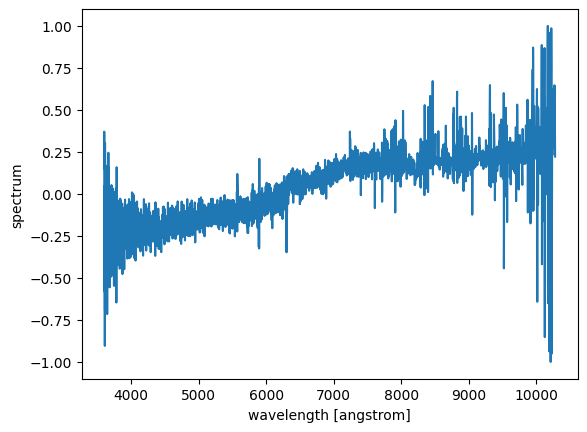

In [58]:
plt.figure()
plt.plot(wavelength, specs[137])
plt.xlabel('wavelength [angstrom]')
plt.ylabel('spectrum')

In [59]:
# -----------------------------
# 0) Hyperparameters
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_WAVELENGTH = 4556
LATENT_DIM   = 128
COND_DIM     = 4      # the number of inputs (the number of galaxies' properties)
BATCH_SIZE   = 64
LR           = 2e-6
N_CRITIC     = 5      # the number of updates of D per 1 update of G
LAMBDA_GP    = 10.0   # gradient penalty coefficient
EPOCHS       = 10

In [60]:
# -----------------------------
# 1) Dataset class
# -----------------------------
class GalaxySpecDS(Dataset):
    def __init__(self, specs, conds):
        """
        specs: shape [N, N_WAVELENGTH]
        conds: shape [N, COND_DIM]
        """
        self.specs = torch.tensor(specs, dtype=torch.float32)
        self.conds = torch.tensor(conds, dtype=torch.float32)

    def __len__(self): return len(self.specs)
    def __getitem__(self, i):
        return self.specs[i], self.conds[i]

In [61]:
# -----------------------------
# 2) Generator / Discriminator with condition
# -----------------------------
class CondMLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, out_dim)
        )
    def forward(self, c): return self.net(c)

class Gen1D(nn.Module):
    def __init__(self, latent_dim, cond_dim, out_len):
        super().__init__()
        self.cond_proj = CondMLP(cond_dim, 64)
        self.fc = nn.Linear(latent_dim + 64, 1024)
        self.fc2 = nn.Linear(1024, out_len)

    def forward(self, z, cond):
        c = self.cond_proj(cond)
        h = torch.cat([z, c], dim=1)
        h = F.leaky_relu(self.fc(h), 0.2)
        out = self.fc2(h)
        return out

class Disc1D(nn.Module):
    def __init__(self, cond_dim, in_len):
        super().__init__()
        self.cond_proj = CondMLP(cond_dim, 64)
        self.fc = nn.Sequential(
            nn.Linear(in_len + 64, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )
    def forward(self, x, cond):
        c = self.cond_proj(cond)
        h = torch.cat([x, c], dim=1)
        return self.fc(h).squeeze(1)

class Gen1D_Deep(nn.Module):
    def __init__(self, latent_dim, cond_dim, out_len):
        super().__init__()
        self.cond_proj = CondMLP(cond_dim, 128)
        self.fc1 = nn.Linear(latent_dim + 128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, out_len)
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(2048)
        self.bn3 = nn.BatchNorm1d(2048)

    def forward(self, z, cond):
        c = self.cond_proj(cond)
        h = torch.cat([z, c], dim=1)
        h = F.leaky_relu(self.bn1(self.fc1(h)), 0.2)
        h = F.leaky_relu(self.bn2(self.fc2(h)), 0.2)
        h = F.leaky_relu(self.bn3(self.fc3(h)), 0.2)
        out = self.fc4(h)
        return out

# Discriminator を深くする
class Disc1D_Deep(nn.Module):
    def __init__(self, cond_dim, in_len):
        super().__init__()
        self.cond_proj = CondMLP(cond_dim, 128)
        self.fc1 = nn.Linear(in_len + 128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 1)
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(2048)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, x, cond):
        c = self.cond_proj(cond)
        h = torch.cat([x, c], dim=1)
        h = F.leaky_relu(self.bn1(self.fc1(h)), 0.2)
        h = F.leaky_relu(self.bn2(self.fc2(h)), 0.2)
        h = F.leaky_relu(self.bn3(self.fc3(h)), 0.2)
        out = self.fc4(h).squeeze(1)
        return out

In [62]:
# -----------------------------
# 3) Gradient penalty
# -----------------------------
def gradient_penalty(D, real, fake, cond):
    B = real.size(0)
    eps = torch.rand(B, 1, device=real.device)
    x_hat = eps*real + (1-eps)*fake
    x_hat.requires_grad_(True)
    d_hat = D(x_hat, cond)
    grad = torch.autograd.grad(d_hat, x_hat,
                               torch.ones_like(d_hat),
                               create_graph=True, retain_graph=True,
                               only_inputs=True)[0]
    gp = ((grad.norm(2, dim=1) - 1.0) ** 2).mean()
    return gp

In [63]:
# -----------------------------
# 4) model initialization
# -----------------------------
G = Gen1D_Deep(LATENT_DIM, COND_DIM, N_WAVELENGTH).to(DEVICE)
D = Disc1D_Deep(COND_DIM, N_WAVELENGTH).to(DEVICE)

g_opt = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.9))
d_opt = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.9))

In [64]:
# -----------------------------
# 5) DataLoader
# -----------------------------
# conds  = metallicity.reshape(-1, 1)
conds = np.concatenate([metallicity.reshape(-1, 1), smass.reshape(-1, 1), ages.reshape(-1, 1), z.reshape(-1, 1)], axis=1)
specs_train, specs_test, conds_train, conds_test = train_test_split(specs, conds, test_size=0.2, random_state=42)
ds_train = GalaxySpecDS(specs_train, conds_train)
loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


In [65]:
# -----------------------------
# 6) trianing loop
# -----------------------------
for epoch in range(EPOCHS):
    for real, cond in loader:
        real, cond = real.to(DEVICE), cond.to(DEVICE)

        # --- update of D ---
        for _ in range(N_CRITIC):
            z = torch.randn(BATCH_SIZE, LATENT_DIM, device=DEVICE)
            fake = G(z, cond).detach()
            d_real = D(real, cond).mean()
            d_fake = D(fake, cond).mean()
            gp = gradient_penalty(D, real, fake, cond) * LAMBDA_GP
            d_loss = (d_fake - d_real) + gp
            d_opt.zero_grad(); d_loss.backward(); d_opt.step()

        # --- update of G ---
        z = torch.randn(BATCH_SIZE, LATENT_DIM, device=DEVICE)
        fake = G(z, cond)
        g_loss = -D(fake, cond).mean()
        g_opt.zero_grad(); g_loss.backward(); g_opt.step()

    print(f"[{epoch+1}/{EPOCHS}] D:{d_loss.item():.3f}  G:{g_loss.item():.3f}")



[1/10] D:-0.183  G:0.149
[2/10] D:-0.420  G:0.217
[3/10] D:-0.477  G:0.291
[4/10] D:-0.931  G:0.365
[5/10] D:-1.202  G:0.468
[6/10] D:-1.434  G:0.528
[7/10] D:-1.890  G:0.595
[8/10] D:-1.932  G:0.640
[9/10] D:-1.755  G:0.688
[10/10] D:-1.189  G:0.740


In [66]:
def sample_spectrum(cond, n=1):
    cond = torch.tensor([cond]*n, dtype=torch.float32, device=DEVICE)  # shape: (n, 2)
    z = torch.randn(n, LATENT_DIM, device=DEVICE)
    G.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        s = G(z, cond).cpu().numpy()
    return s

In [67]:
# -----------------------------
# 7) test generation
# -----------------------------
generated = sample_spectrum(conds_test[0], n=1)
print("generated shape:", generated.shape)

generated shape: (1, 4556)


In [68]:
generated[0]

array([-0.5660016 ,  0.30545884,  0.38296393, ..., -0.36034316,
        0.0559482 ,  0.5775875 ], dtype=float32)

In [69]:
specs_test[0]

array([-7.1081555e-01, -7.9320145e-01, -6.7241782e-01, ...,
        2.2390485e-01, -5.1778555e-04, -4.2421520e-02], dtype=float32)

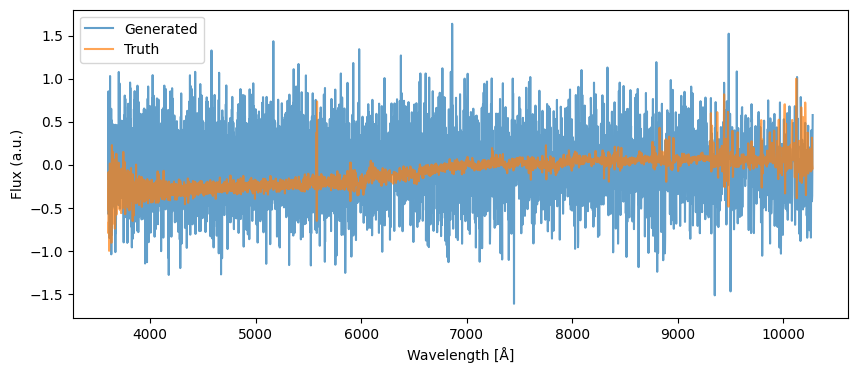

In [70]:
# plot generated spectrum
plt.figure(figsize=(10,4))
plt.plot(wavelength, generated[0], label="Generated", alpha=0.7)
plt.plot(wavelength, specs_test[0], label="Truth", alpha=0.7)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux (a.u.)")
plt.legend()
plt.show()